Here I will just induce a bit flip error myself, an check if the bit flip code an correct it for 2 billiont quantum adder. Everything is run in AER Simulator

In [1]:
from qiskit import*
import qiskit.circuit.library as qulib

control_x1 = qulib.XGate().control(2, ctrl_state='01')
control_x2 = qulib.XGate().control(2, ctrl_state='10')

def encode_qubits(qc, a,b,c): # Encoding the qubits using cx gate |a> --> |00a>
    #qc is the quantum circuit
    #a,b,c are the bits for encoding
    
    qc.cx(a,b)
    qc.cx(a,c)

def error_correction(qc, a,b,c, p1,p2):
    #a,b,c are the bits for encoding
    # p1 and p2 are for parity check
    #Parity Check (Error Syndrome)
    qc.cx(a, p1)
    qc.cx(b, p1)
    qc.cx(b, p2)
    qc.cx(c, p2)

    #Creating custom gates for implementing multi control of qubitserror correction
    qc.ccx(p1, p2, b)  # Correct qubit 1 if needed
    qc.append(control_x1, [p1, p2, a])  # Conditional correction for qubit 0
    qc.append(control_x2, [p1, p2, c])  # Conditional correction for qubit 2

    #reset to 0 for reuse as parity
    qc.reset(p1)
    qc.reset(p2)
    qc.barrier() # to prevent gates flowing around

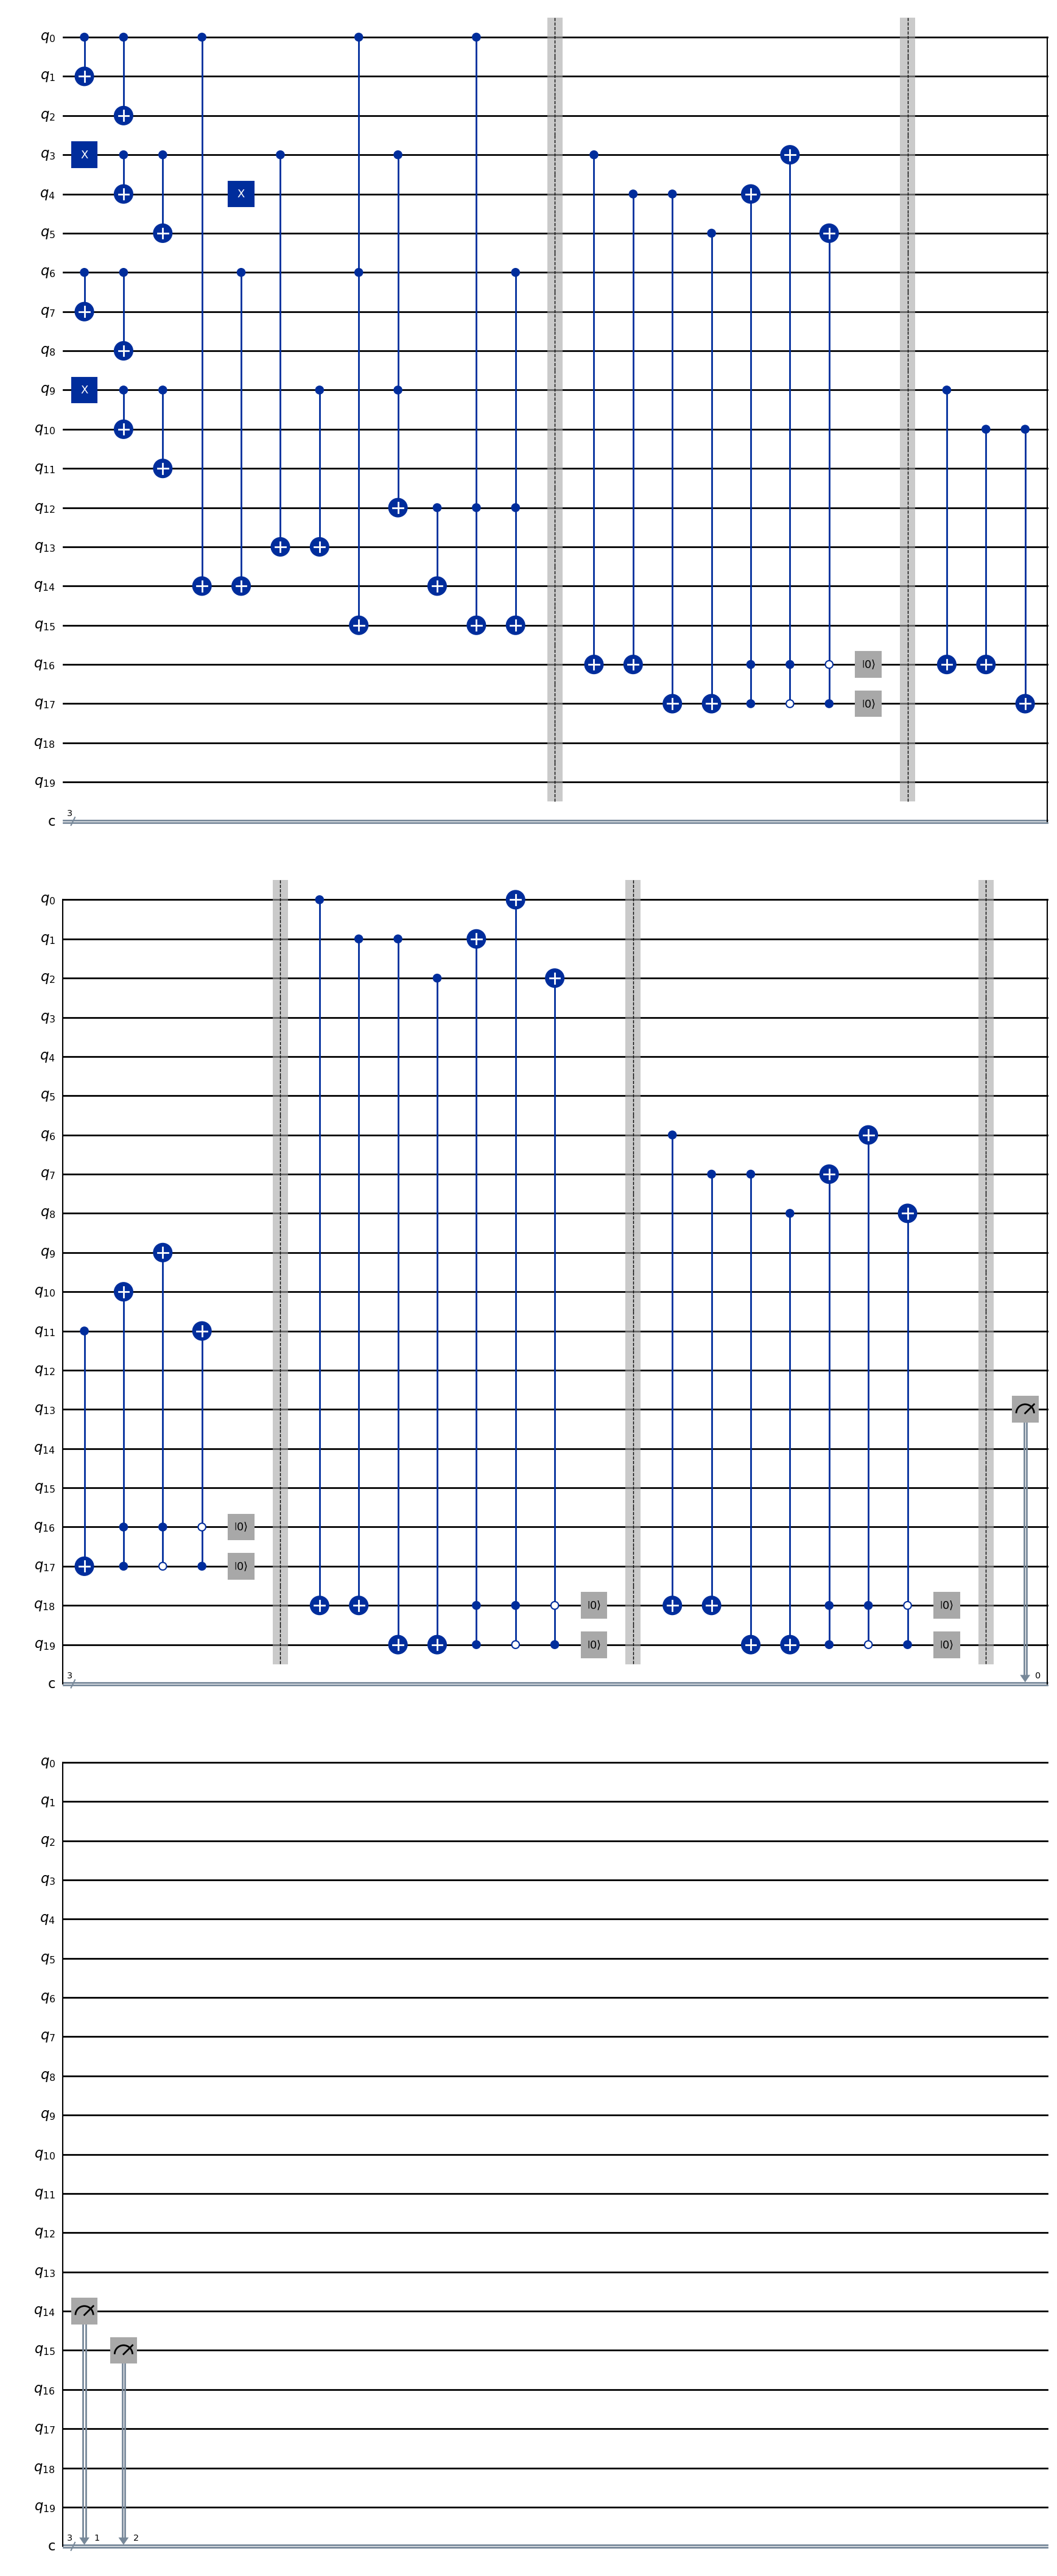

In [5]:
qc = QuantumCircuit(20,3)

#We will add |ab> + |cd>
# a - 0, encoding - 0,1,2
# b - 3, encoding - 3,4,5
# c - 6, encoding - 6,7,8
# d - 9, encoding - 9,10,11

#S1 - 13
#S2 - 14 
#C - 15
#C' temporary carry for b + d

#16 and 17 parity check for b and d
#18 and 19 parity check for b and d

#Step 1: Initializing qubits
qc.x(3) #|01>
qc.x(9) #|01>

#Step 2: Encoding qubits
encode_qubits(qc,0,1,2) #a
encode_qubits(qc,3,4,5) #b
encode_qubits(qc,6,7,8) #c
encode_qubits(qc,9,10,11) #d

#Step 3: Full adder logic

#|b> + |d> 
qc.cx(3,13) 
qc.cx(9,13)

#temporary carry
qc.ccx(3,9,12)

#|a> + |c> 
qc.cx(0,14)
qc.cx(6,14)

#add temporary carry
qc.cx(12,14)

# main carry controlled by a,c and temporary carry 
qc.ccx(0,6,15)
qc.ccx(0,12,15)
qc.ccx(6,12,15)

qc.x(4) #-----BIT FLIP ERROR-------

qc.barrier()

# Step 4: Parity check and error correction
error_correction(qc,3,4,5,16,17) #b
error_correction(qc,9,10,11,16,17) #d
error_correction(qc,0,1,2,18,19) #a
error_correction(qc,6,7,8,18,19) #c


#Measurement
qc.measure([13,14,15],[0,1,2])

#drawing the circuit
qc.draw('mpl')

In [6]:
from qiskit_aer import AerSimulator
simulator_aer = AerSimulator()

result = simulator_aer.run(qc, shots = 3290).result()
counts_aer = result.get_counts()
print(counts_aer)

{'010': 3290}


It shows the correct result. It Works!!!